Kompletny projekt klasyfikacji w Tensorflow/keras obejamujcy:


*   preprocessing
*   konstrukcje modelu
*   PCA
*   Shap




In [1]:
import os
path = os.path.expanduser("/content/drive/MyDrive/UM/dataset/")

In [2]:
import glob
import pandas as pd
import os

dfs=[]
for filename in glob.glob(path+"ln*.csv"):
  dfs.append(pd.read_csv(filename,sep=";"))\

data=pd.concat(dfs)

In [3]:
data.shape

(200000, 151)

In [4]:
data

,p0,p1,b0,b1,M11,M22,M12SQ,M22Sign,Re1,Im1,...,_bkg_4.363,_bkg_4.365,_bkg_4.367,_bkg_4.369,_bkg_4.371,_bkg_4.373,_bkg_4.375,_bkg_4.377,_bkg_4.379,classes
0,465.582952,-10.691788,391.028334,25.128374,1.172844,-0.380742,0.799431,0,3.750039,0.000000,...,3610.600119,3618.298749,3625.930988,3633.497081,3640.997267,3648.431779,3655.800845,3663.104690,3670.343532,0.0
1,532.925042,-33.024764,273.604260,-16.577703,3.081851,-0.083519,0.306468,0,2.500713,0.000000,...,-174.286835,-175.774167,-177.262386,-178.751439,-180.241272,-181.731833,-183.223068,-184.714926,-186.207353,0.0
2,303.448035,-9.419148,634.608268,-27.127518,-0.570157,-0.307506,0.331294,0,4.015800,0.000000,...,490.963872,489.792731,488.604428,487.399127,486.176987,484.938169,483.682830,482.411126,481.123213,0.0
3,33.536130,13.265676,269.359835,-34.235181,3.983191,-0.383891,0.265660,0,0.000000,0.189464,...,-1587.883322,-1592.952574,-1597.998801,-1603.022015,-1608.022221,-1612.999427,-1617.953637,-1622.884852,-1627.793074,0.0
4,343.741516,-0.277088,516.481990,17.514036,-3.801425,-0.325488,0.634675,0,0.759246,0.000000,...,3529.650758,3536.664778,3543.612019,3550.492748,3557.307230,3564.055722,3570.738477,3577.355741,3583.907759,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,36.675449,16.297370,279.106522,7.382439,3.392874,0.237598,0.359129,1,2.019943,0.000000,...,1742.811043,1746.182423,1749.520494,1752.825392,1756.097253,1759.336210,1762.542392,1765.715927,1768.856941,3.0
7996,504.863628,-26.746462,283.598085,20.263933,0.457369,0.095377,0.005204,1,4.009545,0.000000,...,2779.853164,2785.847056,2791.790076,2797.682410,2803.524238,2809.315735,2815.057074,2820.748422,2826.389945,3.0
7997,181.156922,-34.520551,18.669810,-0.973788,-0.409125,0.216165,1.206525,1,3.909785,0.000000,...,0.552376,0.482563,0.412480,0.342130,0.271517,0.200647,0.129523,0.058149,-0.013471,3.0
7998,124.228828,-14.469293,112.350054,-3.995951,-1.796688,0.155366,0.004226,1,3.612302,0.000000,...,150.692729,150.647718,150.598592,150.545384,150.488124,150.426844,150.361573,150.292343,150.219182,3.0


In [5]:
from numpy.core.numeric import full
import numpy as np

fulldataset=data

lowe=4.251
upe=4.379

widthe=0.002

longCols=["M22Sign","RS1","RS2","RS3","RS4"]
floatCols=[col for col in fulldataset.columns if col not in longCols]

fulldataset[longCols]=fulldataset[longCols].astype("long")
fulldataset[floatCols]=fulldataset[floatCols].astype("float32")

fulldataset=fulldataset[(fulldataset.RS3==4) | (fulldataset.RS3==2)]

hyperparam_cols=["p0","p1","b0","M11","M22","M12SQ","M22Sign","Re1","Im1","RS1",
                "Re2","Im2","RS2","Re3","Im3","RS3","Re4","Im4","RS4"]

hyperparams=fulldataset[hyperparam_cols]

x_cols=[col for col in fulldataset.columns if col not in hyperparam_cols]

e=[energy for  energy in x_cols if energy[:4]=="_sig"]
e=[float(energy.split("_")[2]) for energy in e]

e=np.array([energy for energy in e if energy<=upe and energy>=lowe])

sig_c_energies=["_sig_"+str(energy) for energy in e]
bkg_c_energies=["_bkg_"+str(energy) for energy in e]

X_c=fulldataset[sig_c_energies].values+fulldataset[bkg_c_energies].values
Y=np.ravel(fulldataset["classes"])

In [6]:
mu, sigma=0,1

noiseStd=0.05

dataX_sig=fulldataset[sig_c_energies].values
dataX_bkg=fulldataset[bkg_c_energies].values

noise=np.zeros(dataX_sig.shape)

for i in range(dataX_sig.shape[0]):
  noise[i]=np.random.normal(mu,sigma,size=(dataX_sig.shape[1]))*dataX_sig[i,:].max()*noiseStd

X_noise=dataX_sig+noise

X_completed=X_noise+fulldataset[bkg_c_energies].values

In [7]:
from sklearn.preprocessing import minmax_scale

X_scaled=minmax_scale(X_completed,axis=1)

In [8]:
from tensorflow.keras.utils import to_categorical

Yenc=to_categorical(Y)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test=train_test_split(X_scaled,Yenc,test_size=.3,random_state=1)

In [10]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

def makeModel(dropout=False):
  model=Sequential()

  model.add(Dense(400,activation="relu",input_shape=(X_train.shape[1],)))
  if dropout:
    model.add(Dropout(.2))

  model.add(Dense(200,activation="relu"))
  if dropout:
    model.add(Dropout(.5))

  model.add(Dense(4,activation="softmax"))

  return model

model=makeModel()
model.summary()
  

Instructions for updating:
non-resource variables are not supported in the long term


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               26400     
                                                                 
 dense_1 (Dense)             (None, 200)               80200     
                                                                 
 dense_2 (Dense)             (None, 4)                 804       
                                                                 
Total params: 107,404
Trainable params: 107,404
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["categorical_accuracy"])
history=model.fit(X_train,Y_train,epochs=60,batch_size=1024,validation_split=.25,verbose=1)

Train on 105000 samples, validate on 35000 samples
Epoch 1/60
105000/105000 [==============================] - 3s 31us/sample - loss: 0.5523 - categorical_accuracy: 0.7871 - val_loss: 0.3523 - val_categorical_accuracy: 0.8662
Epoch 2/60
 18432/105000 [====>.........................] - ETA: 0s - loss: 0.3308 - categorical_accuracy: 0.8772

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


105000/105000 [==============================] - 0s 4us/sample - loss: 0.3004 - categorical_accuracy: 0.8876 - val_loss: 0.2906 - val_categorical_accuracy: 0.8925
Epoch 3/60
105000/105000 [==============================] - 0s 5us/sample - loss: 0.2646 - categorical_accuracy: 0.8988 - val_loss: 0.2680 - val_categorical_accuracy: 0.8967
Epoch 4/60
105000/105000 [==============================] - 0s 4us/sample - loss: 0.2456 - categorical_accuracy: 0.9047 - val_loss: 0.2388 - val_categorical_accuracy: 0.9078
Epoch 5/60
105000/105000 [==============================] - 0s 4us/sample - loss: 0.2345 - categorical_accuracy: 0.9088 - val_loss: 0.2311 - val_categorical_accuracy: 0.9103
Epoch 6/60
105000/105000 [==============================] - 0s 4us/sample - loss: 0.2222 - categorical_accuracy: 0.9124 - val_loss: 0.2180 - val_categorical_accuracy: 0.9160
Epoch 7/60
105000/105000 [==============================] - 0s 4us/sample - loss: 0.2139 - categorical_accuracy: 0.9159 - val_loss: 0.2168 - 

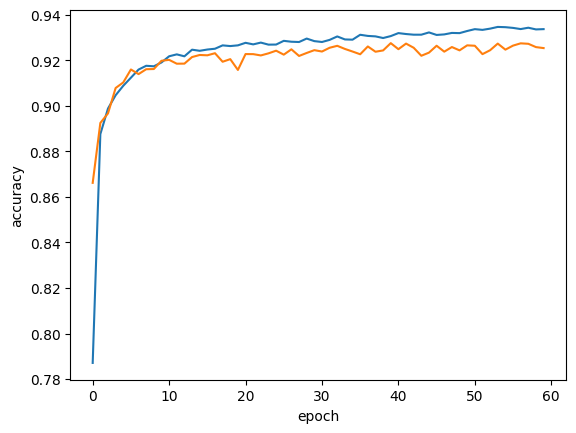

In [12]:
from matplotlib import pyplot as plt

plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [13]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
Y_pred = model.predict(X_test)
Y_pred



/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([[9.9997211e-01, 1.6492451e-05, 3.1324373e-07, 1.1171116e-05],
       [4.8949100e-06, 6.6130841e-04, 1.9966155e-05, 9.9931383e-01],
       [9.9486309e-01, 5.1345397e-03, 1.6322839e-06, 7.2252300e-07],
       ...,
       [9.9999988e-01, 1.8756174e-09, 6.3939858e-08, 1.2430250e-08],
       [2.3758961e-04, 9.9961323e-01, 1.7926320e-08, 1.4921004e-04],
       [9.9999738e-01, 2.0965888e-06, 2.9036526e-10, 4.9058661e-07]],
      dtype=float32)

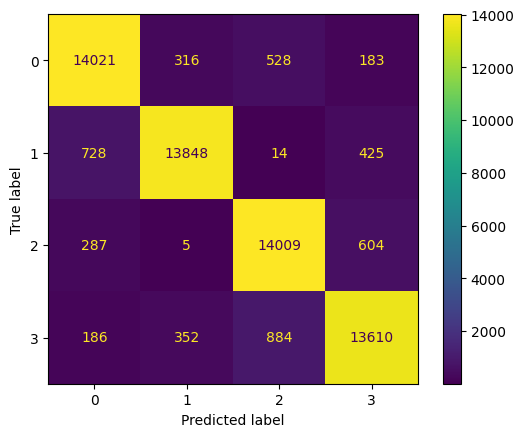

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(Y_test, axis=1)
cm = confusion_matrix(Y_test, Y_pred)
cd = ConfusionMatrixDisplay(cm)

cd.plot()

#Bootstrap

In [15]:
test_filename = '/content/drive/MyDrive/UM/dataset/boot_all.csv'

test_file = pd.read_csv(test_filename, sep=';')
test_file

,4.251,4.253,4.255,4.257,4.259,4.261,4.263,4.265,4.267,4.269,...,4.361,4.363,4.365,4.367,4.369,4.371,4.373,4.375,4.377,4.379
0,446.533076,438.379125,407.247021,434.812468,508.723620,482.135035,485.607803,471.258107,474.836793,427.637539,...,617.347380,596.925025,618.582704,652.990253,699.447274,650.406534,756.954652,759.292899,711.710069,693.920066
1,436.612434,443.796657,411.109697,466.397711,485.010034,460.772841,449.833178,505.705531,464.342050,458.429792,...,615.923238,619.068944,640.737550,689.961452,690.829490,747.253092,658.751022,754.745363,717.797174,686.210789
2,409.944610,423.314691,456.568147,449.435938,476.559607,458.146926,495.549395,473.137127,430.098324,482.154740,...,665.366786,635.005570,617.258042,628.297788,714.762215,668.162287,659.732643,794.124573,712.335171,680.559494
3,401.631186,488.070562,407.673938,470.025276,480.744273,471.212496,427.056821,508.525476,496.063428,437.078943,...,661.334271,629.006725,621.479068,693.533651,679.813577,677.866229,673.202506,715.432954,688.384233,671.319548
4,446.958033,429.405371,459.583535,463.354768,424.723268,484.351783,480.606332,469.827838,467.459439,499.091906,...,686.897944,697.736786,652.143094,656.679681,680.301917,702.604237,638.596272,720.730468,704.126258,731.632052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,448.325858,448.473889,445.317247,468.843204,485.177881,458.843312,495.522545,507.369533,423.450628,449.054664,...,664.626437,566.656812,657.764167,623.258647,637.752262,658.446036,661.303099,693.379934,725.240278,699.900649
9996,469.051630,433.223556,436.329011,480.901769,508.548302,405.919631,431.457320,479.853673,450.449321,488.718783,...,651.899041,643.941189,666.282003,670.793005,622.470490,710.716296,681.038062,707.193864,740.457687,749.782731
9997,462.534250,478.138673,442.318207,466.913966,439.566932,432.977835,518.998326,484.175185,467.637037,480.649470,...,733.431481,655.658027,640.305332,601.693827,679.490031,637.580214,662.781653,724.699874,667.611201,716.288552
9998,457.257356,444.649633,401.256127,497.831426,445.883662,438.714310,456.866597,517.231582,468.236685,405.941652,...,703.227146,662.094378,663.304358,671.084559,655.894640,676.374454,673.712007,746.962948,702.625306,724.960867


In [16]:
x_scaled = minmax_scale(test_file, axis=1)

y_pred = model.predict(x_scaled)
y_pred

array([[1.7709597e-03, 1.9723764e-05, 5.3416244e-03, 9.9286771e-01],
       [4.8317588e-03, 3.3065193e-05, 3.6487442e-03, 9.9148631e-01],
       [5.6789932e-03, 1.5616120e-04, 6.6866241e-03, 9.8747814e-01],
       ...,
       [3.0490372e-03, 7.0119959e-06, 2.5588624e-02, 9.7135532e-01],
       [1.3544926e-03, 1.0457634e-05, 2.2749016e-03, 9.9636012e-01],
       [4.7515899e-02, 1.4761808e-05, 1.4513057e-01, 8.0733871e-01]],
      dtype=float32)

In [17]:
plt.rcParams["figure.figsize"] = (10,6)

In [18]:
test_filename_kp = '/content/drive/MyDrive/UM/dataset/boot_kp.csv'

test_file_kp = pd.read_csv(test_filename_kp, sep=';')
x_scaled_kp = minmax_scale(test_file_kp, axis=1)

y_pred_kp = model.predict(x_scaled_kp)


In [19]:
test_filename_weight = '/content/drive/MyDrive/UM/dataset/boot_weight.csv'

test_file_weight = pd.read_csv(test_filename_weight, sep=';')
x_scaled_weight = minmax_scale(test_file_weight, axis=1)

y_pred_weight = model.predict(x_scaled_weight)


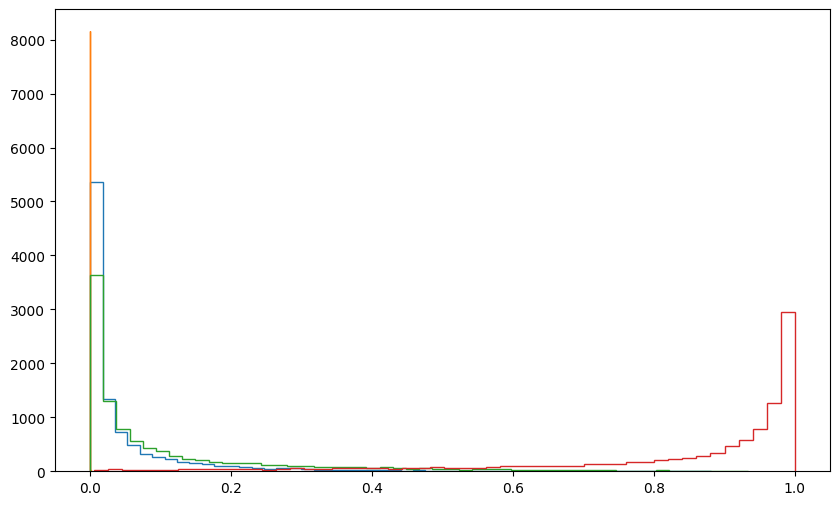

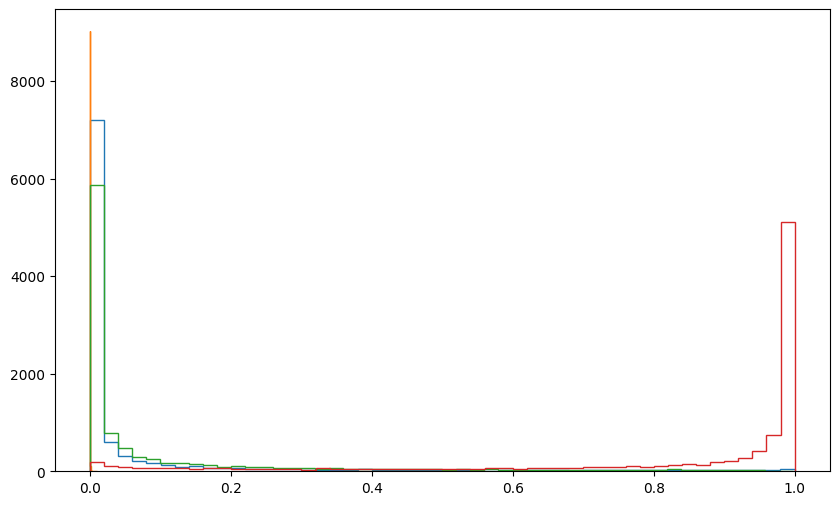

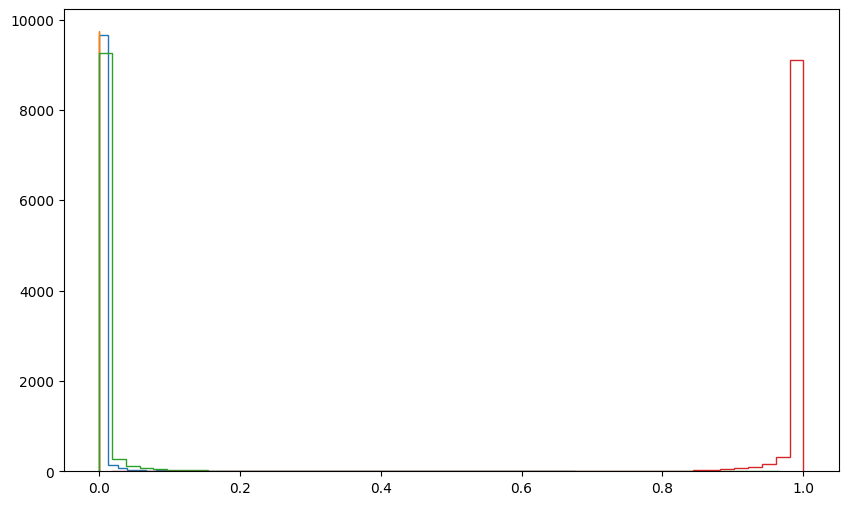

In [20]:
class0 = y_pred[:, 0]
class1 = y_pred[:, 1]
class2 = y_pred[:, 2]
class3 = y_pred[:, 3]


counts, bins = np.histogram(class0, 50)
plt.stairs(counts, bins)

counts, bins = np.histogram(class1, 50)
plt.stairs(counts, bins)

counts, bins = np.histogram(class2, 50)
plt.stairs(counts, bins)

counts, bins = np.histogram(class3, 50)
plt.stairs(counts, bins)

plt.show()

class0 = y_pred_kp[:, 0]
class1 = y_pred_kp[:, 1]
class2 = y_pred_kp[:, 2]
class3 = y_pred_kp[:, 3]


counts, bins = np.histogram(class0, 50)
plt.stairs(counts, bins)

counts, bins = np.histogram(class1, 50)
plt.stairs(counts, bins)

counts, bins = np.histogram(class2, 50)
plt.stairs(counts, bins)

counts, bins = np.histogram(class3, 50)
plt.stairs(counts, bins)


plt.show()

class0 = y_pred_weight[:, 0]
class1 = y_pred_weight[:, 1]
class2 = y_pred_weight[:, 2]
class3 = y_pred_weight[:, 3]


counts, bins = np.histogram(class0, 50)
plt.stairs(counts, bins)

counts, bins = np.histogram(class1, 50)
plt.stairs(counts, bins)

counts, bins = np.histogram(class2, 50)
plt.stairs(counts, bins)

counts, bins = np.histogram(class3, 50)
plt.stairs(counts, bins)

plt.show()

zbior 1

In [53]:
n_comps=8
from sklearn.decomposition import PCA

pca_train=PCA(n_comps)

In [49]:
train_pca=pca_train.fit_transform(X_test)

In [51]:
np.sum(pca_train.explained_variance_ratio_)

0.9511517024415811

In [58]:
pca_all=PCA(n_comps)

all_pca=pca_all.fit_transform(x_scaled)
np.sum(pca_all.explained_variance_ratio_)

0.31277159243102953

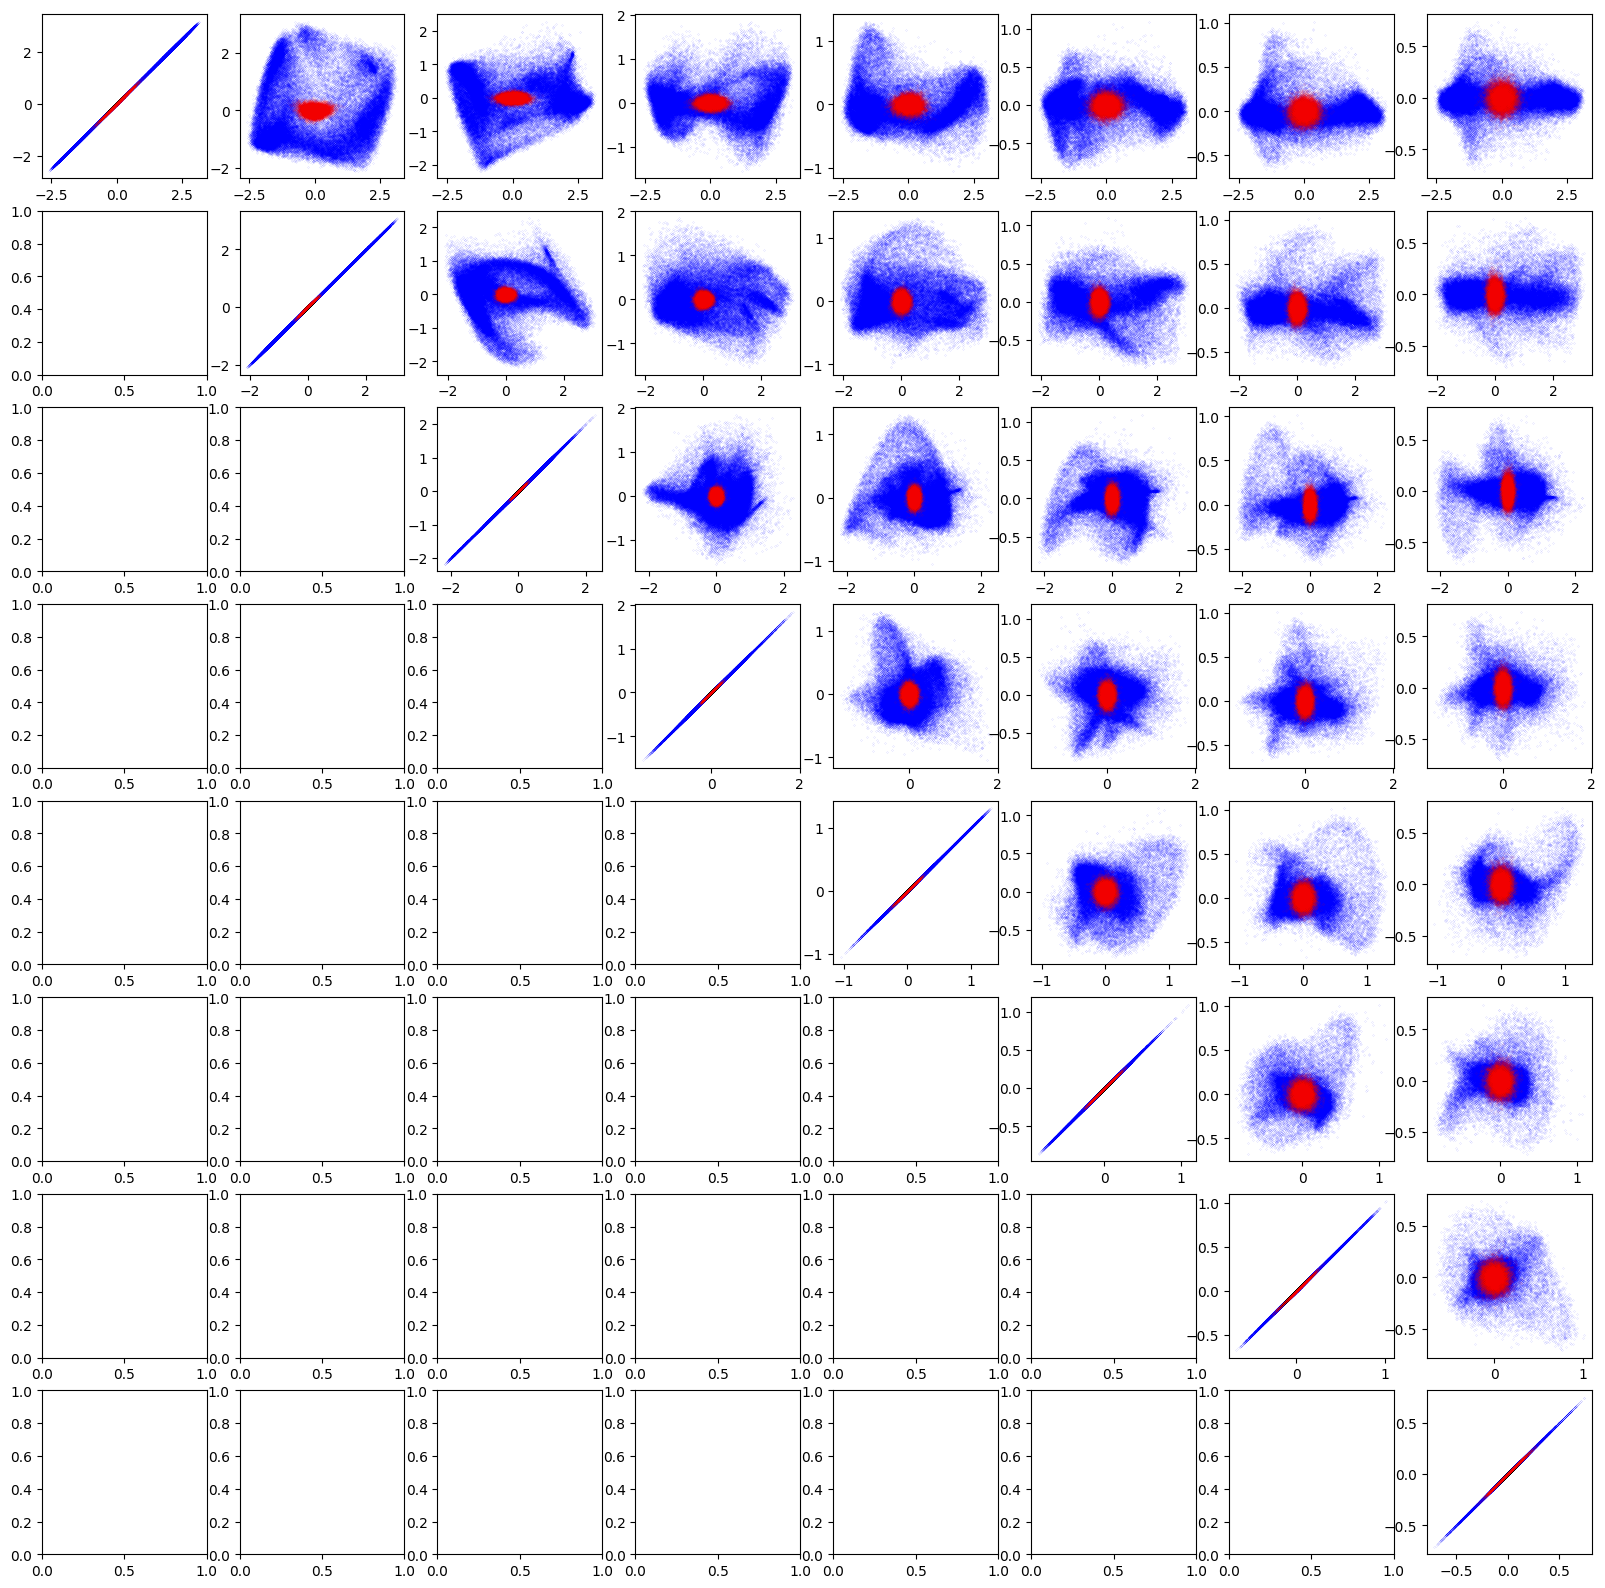

In [67]:
from matplotlib import pyplot as plt

fig,ax=plt.subplots(n_comps,n_comps)

colors=["green","orange","blue","black"]

for i in range(0,n_comps):
  for j in range(i,n_comps):
    ax[i,j].scatter(train_pca[:,i],train_pca[:,j],color='b',marker=".",s=.01)
    ax[i,j].scatter(all_pca[:,i],all_pca[:,j],color='r',marker=".",s=.01)

fig.set_size_inches(20,20)
plt.show()    

zbior 2

In [59]:
pca_all=PCA(n_comps)

all_pca_kp=pca_all.fit_transform(x_scaled_kp)
np.sum(pca_all.explained_variance_ratio_)

0.2616433904414246

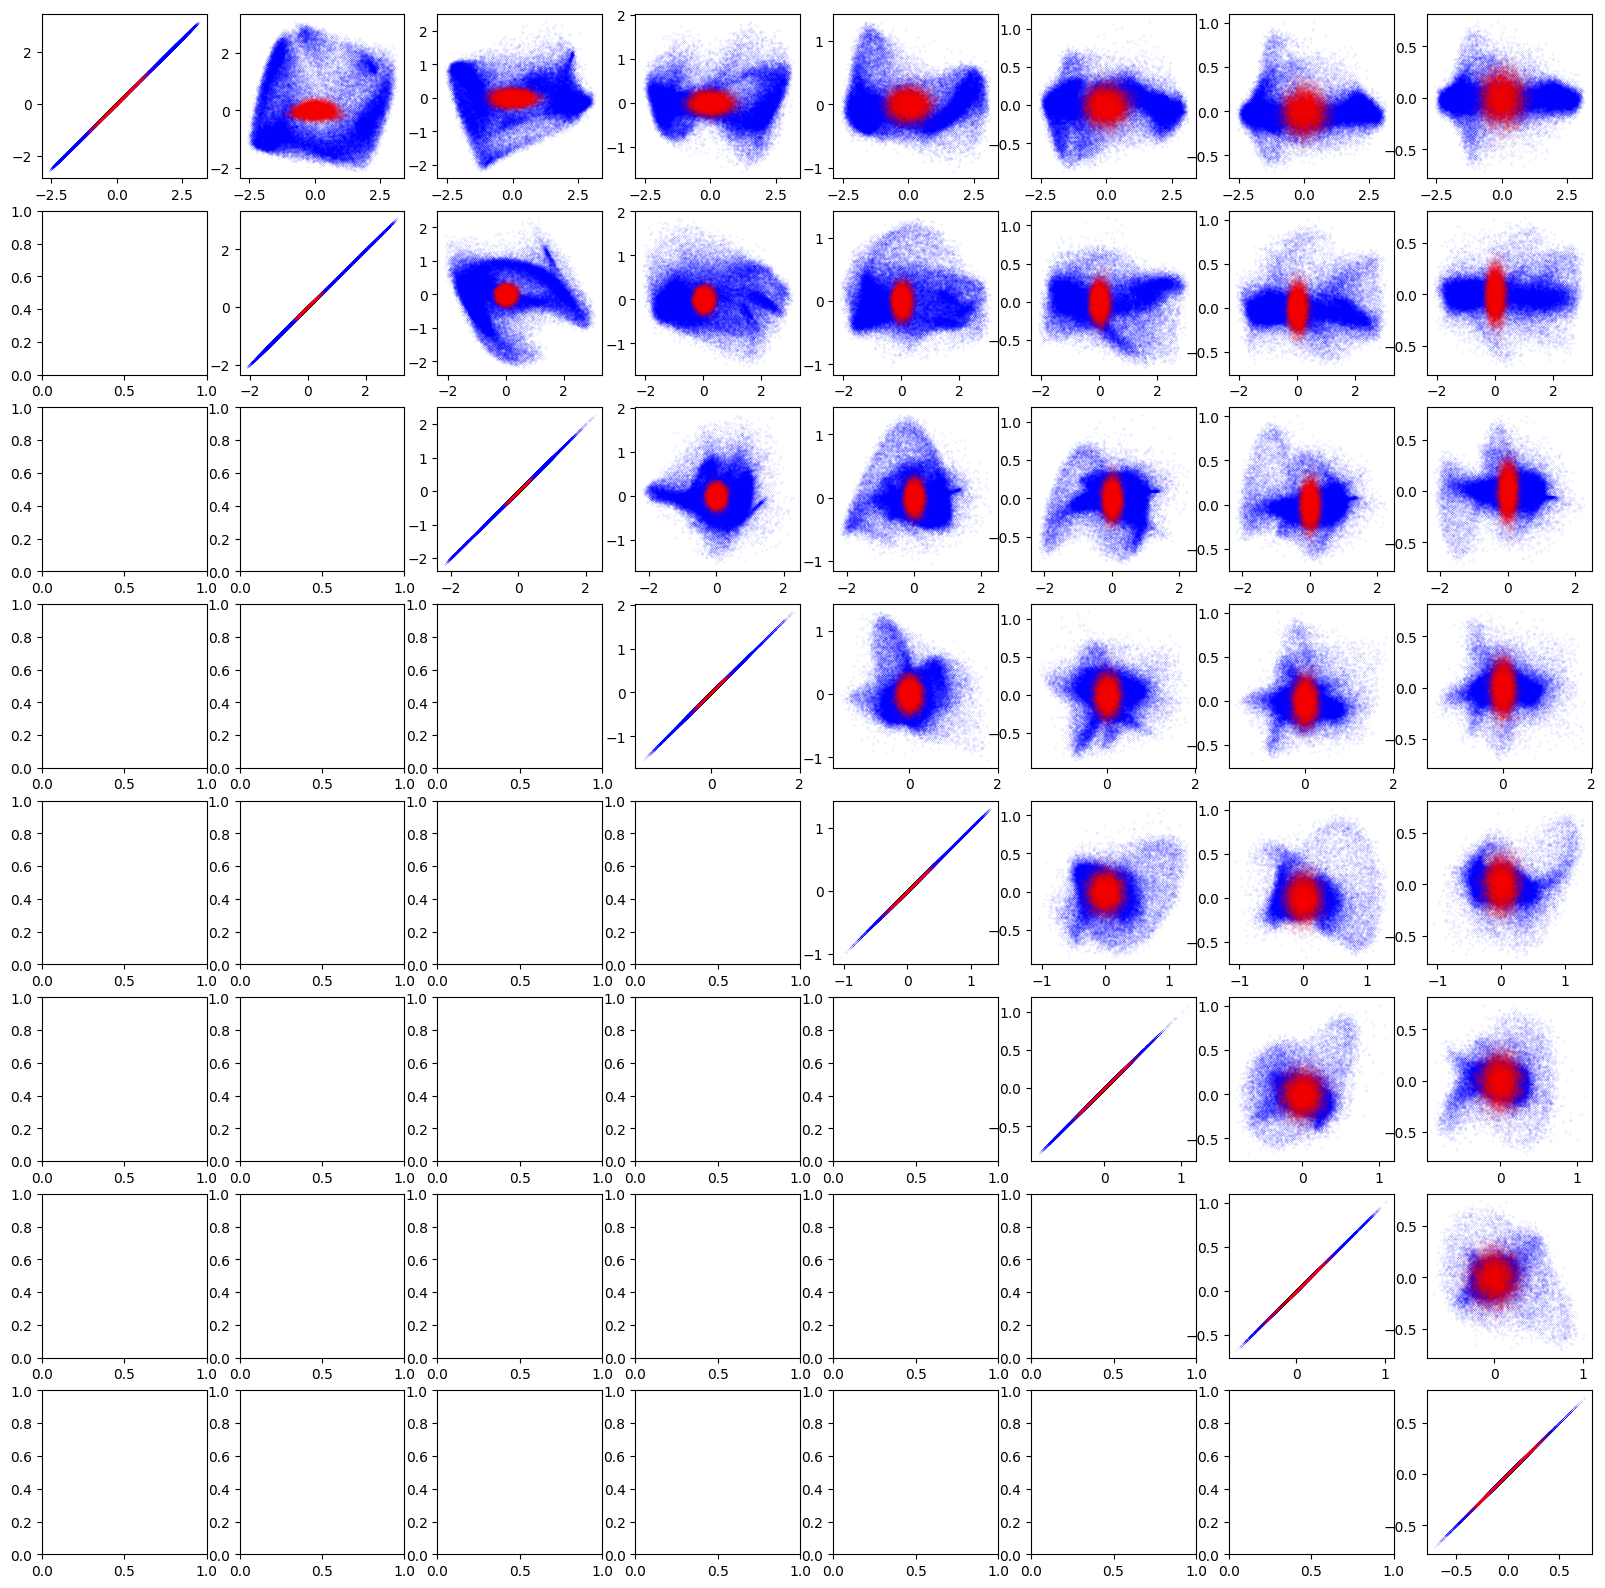

In [64]:
from matplotlib import pyplot as plt

fig,ax=plt.subplots(n_comps,n_comps)

for i in range(0,n_comps):
  for j in range(i,n_comps):
    ax[i,j].scatter(train_pca[:,i],train_pca[:,j],color="b",marker=".",s=.01)
    ax[i,j].scatter(all_pca_kp[:,i],all_pca_kp[:,j],color="r",marker=".",s=.01)

fig.set_size_inches(20,20)
plt.show()    

zbior 3

In [61]:
pca_all=PCA(n_comps)

all_pca_weight=pca_all.fit_transform(x_scaled_weight)
np.sum(pca_all.explained_variance_ratio_)

0.28486338984488363

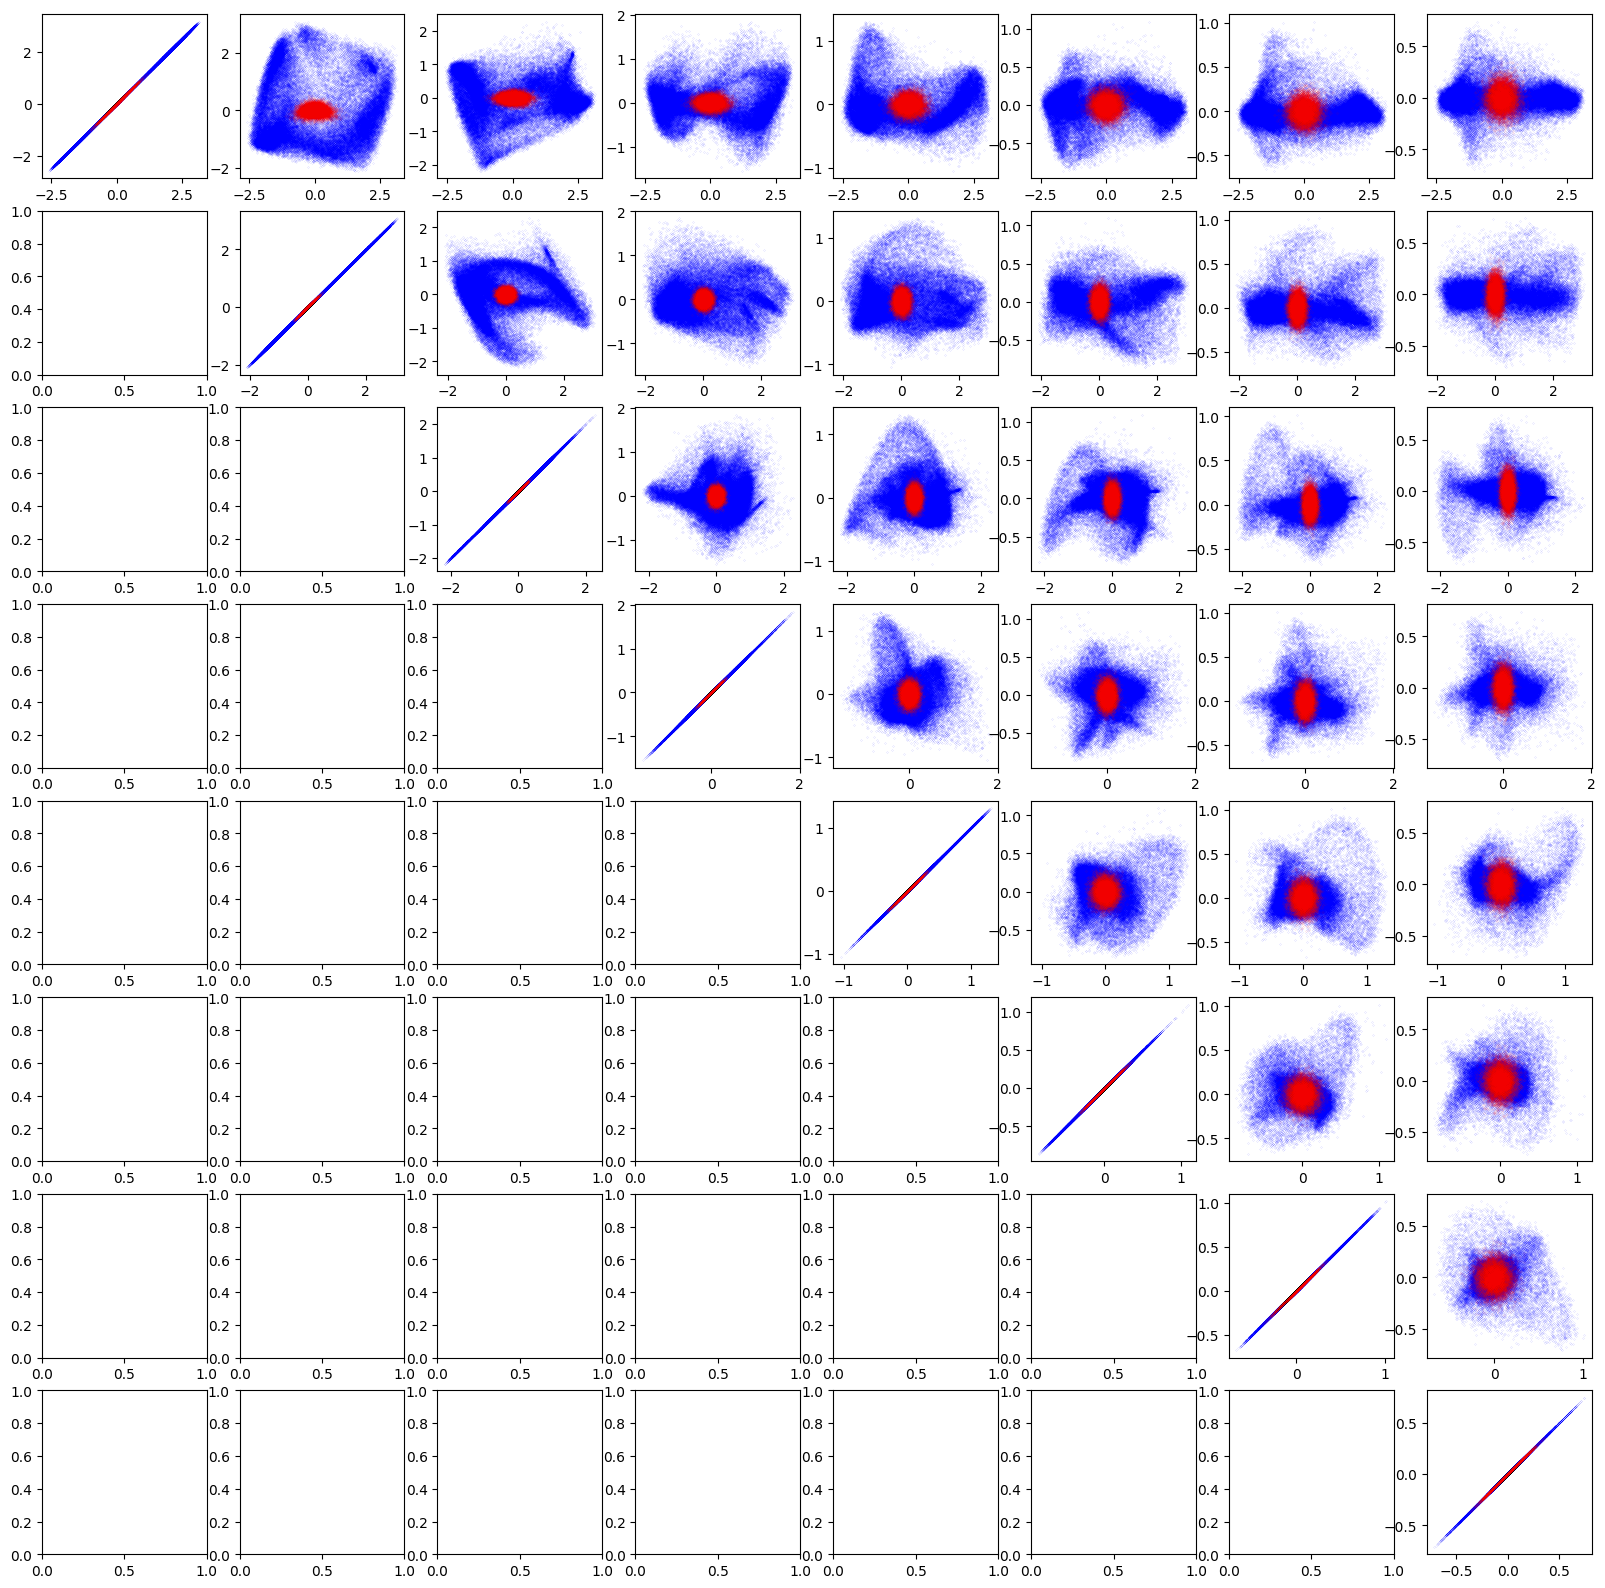

In [66]:
from matplotlib import pyplot as plt

fig,ax=plt.subplots(n_comps,n_comps)

for i in range(0,n_comps):
  for j in range(i,n_comps):
    ax[i,j].scatter(train_pca[:,i],train_pca[:,j],color="b",marker=".",s=.01)
    ax[i,j].scatter(all_pca_weight[:,i],all_pca_weight[:,j],color="r",marker=".",s=.01)

fig.set_size_inches(20,20)
plt.show()    

In [69]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 12.0 MB/s eta 0:00:00


In [74]:
import shap

background=X_train[np.random.choice(X_train.shape[0],100,replace=False)]

explainer=shap.DeepExplainer(
    (model.layers[0].input,model.layers[-1].output),background
)

row=5
print("Class number prediction: "+str(Y_test[row].argmax(axis=0)))
examples=X_test[row:row+1]

shap_values=explainer.shap_values(examples)
feature_names=data.columns[20:-1-65]
class_number=3
sample_number=0

shap.initjs()

shap.force_plot(
    explainer.expected_value[class_number],shap_values[class_number][sample_number],
    feature_names=feature_names
)

Class number prediction: 0


In [81]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout,MaxPooling1D,Flatten

def makeModel(dropout=False):

  activation="elu"
  input_shape=(X_train.shape[1],1)

  model=Sequential()

  model.add(Conv1D(32,3,activation=activation,padding="valid", input_shape=input_shape))
  model.add(MaxPooling1D(2))
  if dropout:
    model.add(Dropout(.2))

  model.add(Conv1D(32,3,activation=activation,padding="valid",kernel_initializer="he_normal"))
  model.add(MaxPooling1D(2))
  if dropout :
    model.add(Dropout(.2))

  model.add(Flatten())

  model.add(Dense(400,activation=activation))

  if dropout:
    model.add(Dropout(.2))

  model.add(Dense(200,activation=activation))

  if dropout:
    model.add(Dropout(.5))

  model.add(Dense(4, activation="softmax"))

  return model
x_train_3d=np.expand_dims(X_train,axis=2)
model=makeModel(True)
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 63, 32)            128       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 31, 32)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 31, 32)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 29, 32)            3104      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 14, 32)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 32)           

In [82]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["categorical_accuracy"])

history=model.fit(x_train_3d,Y_train,epochs=150,batch_size=1024,validation_split=.25,verbose=1)

Train on 105000 samples, validate on 35000 samples
Epoch 1/150
105000/105000 [==============================] - 1s 12us/sample - loss: 0.6343 - categorical_accuracy: 0.7470 - val_loss: 0.4508 - val_categorical_accuracy: 0.8276
Epoch 2/150
105000/105000 [==============================] - 1s 8us/sample - loss: 0.4421 - categorical_accuracy: 0.8288 - val_loss: 0.3748 - val_categorical_accuracy: 0.8565
Epoch 3/150
105000/105000 [==============================] - 1s 8us/sample - loss: 0.3970 - categorical_accuracy: 0.8453 - val_loss: 0.3051 - val_categorical_accuracy: 0.8856
Epoch 4/150
105000/105000 [==============================] - 1s 8us/sample - loss: 0.3596 - categorical_accuracy: 0.8595 - val_loss: 0.2773 - val_categorical_accuracy: 0.8903
Epoch 5/150
105000/105000 [==============================] - 1s 8us/sample - loss: 0.3324 - categorical_accuracy: 0.8695 - val_loss: 0.2620 - val_categorical_accuracy: 0.8986
Epoch 6/150
105000/105000 [==============================] - 1s 7us/sampl

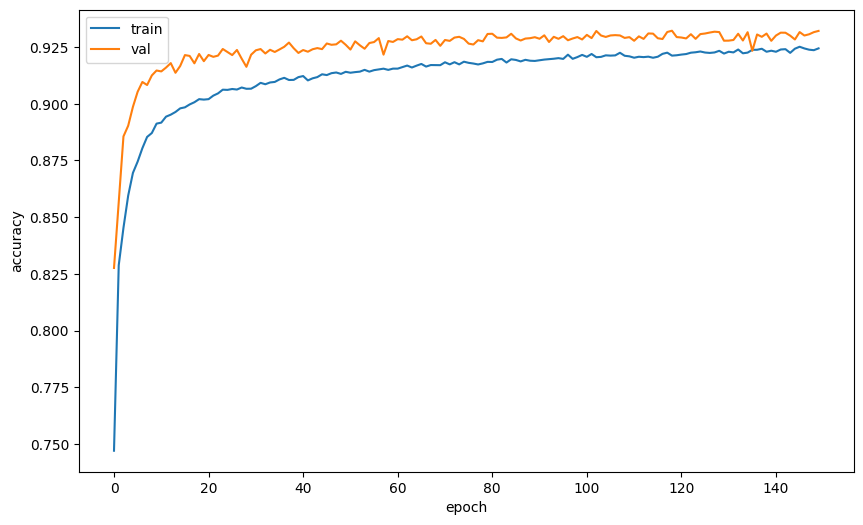

In [83]:
from matplotlib import pyplot as plt

plt.plot(history.history["categorical_accuracy"],label="train")
plt.plot(history.history["val_categorical_accuracy"],label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [96]:
x_test_3d=np.expand_dims(X_test,axis=2)
Y_pred = model.predict(x_test_3d)



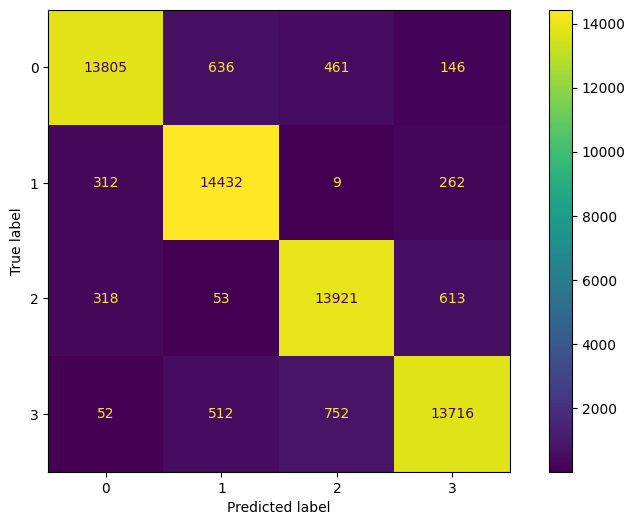

In [97]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Y_test_3d = np.expand_dims(Y_test,axis=2)
Y_pred = np.argmax(Y_pred, axis=1)
# Y_test = np.argmax(Y_test, axis=1)
cm = confusion_matrix(Y_test, Y_pred)
cd = ConfusionMatrixDisplay(cm)

cd.plot()